<a href="https://colab.research.google.com/github/Anderoids/Anderoids/blob/main/Drug_Repurposing_GNN_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, random, math, matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from pathlib import Path
import urllib.request, tarfile

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBED_DIM = 128
BATCH_SIZE = 128
TRAIN_EPOCHS = 5
LR = 1e-3
MC_DROPOUT_SAMPLES = 3
LAMBDA_PATH = 0.1
ENSEMBLE_SIZE = 3
HITS_K = [1,5,10]
PATIENCE = 7
MIN_DELTA = 1e-4
TENSORBOARD_LOGDIR = "runs"
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)


# **Download and extracting the dataset(DRKG)**

In [ ]:

DATA_URL = "https://dgl-data.s3-us-west-2.amazonaws.com/dataset/DRKG/drkg.tar.gz"
DATA_DIR = Path("drkg_data")
DATA_DIR.mkdir(exist_ok=True)
archive_path = DATA_DIR / "drkg.tar.gz"
if not archive_path.exists():
    print("Downloading DRKG...")
    urllib.request.urlretrieve(DATA_URL, archive_path)

if not any(DATA_DIR.iterdir()) or len(list(DATA_DIR.iterdir()))==1:
    print("Extracting...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=DATA_DIR)
    print("Extracted.")



In [ ]:
triples_file = Path("/content/drkg_data/drkg.tsv")

**Loading the entities and relations**

In [ ]:

edges = []
entities = set()
relations = set()

with open(triples_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) < 3:
            parts = line.strip().split()  # fallback
        if len(parts) < 3:
            continue
        h, r, t = parts[0], parts[1], parts[2]
        edges.append((h, r, t))
        entities.update([h, t])
        relations.add(r)

print(f"Loaded {len(edges)} triples, {len(entities)} entities, {len(relations)} relations.")


Loaded 5874261 triples, 97238 entities, 107 relations.


**Heuristic entity typing and node indexing**

In [ ]:

# Entity type heuristic
entity_type_map = {}
for e in entities:
    el = e.lower()
    if 'compound' in el or 'drug' in el or el.startswith('cpd') or 'chem' in el:
        entity_type_map[e]='compound'
    elif 'gene' in el or 'hgnc' in el or el.isupper() and len(e)<=6:
        entity_type_map[e]='gene'
    elif 'disease' in el or 'dis' in el or 'omim' in el:
        entity_type_map[e]='disease'
    elif 'protein' in el: entity_type_map[e]='protein'
    else: entity_type_map[e]='other'

# Node indexing
node_type_to_nodes = defaultdict(list)
for e in entities: node_type_to_nodes[entity_type_map.get(e,'other')].append(e)
node_type_to_id = {nt:{n:i for i,n in enumerate(nlist)} for nt,nlist in node_type_to_nodes.items()}
print("Detected node types:", {k:len(v) for k,v in node_type_to_nodes.items()})


Detected node types: {'compound': 26410, 'other': 28602, 'gene': 37123, 'disease': 5103}


**positive compound and disease pairs**

In [ ]:
compound_type = 'compound'
disease_type = 'disease'


pos_pairs = []
for h, r, t in edges:
    ht, tt = entity_type_map.get(h, 'other'), entity_type_map.get(t, 'other')
    if ht == compound_type and tt == disease_type:
        pos_pairs.append((node_type_to_id[compound_type][h], node_type_to_id[disease_type][t]))
    elif ht == disease_type and tt == compound_type:
        pos_pairs.append((node_type_to_id[compound_type][t], node_type_to_id[disease_type][h]))

pos_pairs = list(set(pos_pairs))
print(f"Found {len(pos_pairs)} positive compound-disease pairs.")


Found 81842 positive compound-disease pairs.


**Compound->gene and disease->gene adjacency**

In [ ]:
compound_to_genes = defaultdict(list)
disease_to_genes = defaultdict(list)
for h,r,t in edges:
    ht,tt = entity_type_map[h], entity_type_map[t]
    if ht==compound_type and tt=='gene': compound_to_genes[node_type_to_id[ht][h]].append(node_type_to_id['gene'][t])
    if tt==compound_type and ht=='gene': compound_to_genes[node_type_to_id[tt][t]].append(node_type_to_id['gene'][h])
    if ht==disease_type and tt=='gene': disease_to_genes[node_type_to_id[ht][h]].append(node_type_to_id['gene'][t])
    if tt==disease_type and ht=='gene': disease_to_genes[node_type_to_id[tt][t]].append(node_type_to_id['gene'][h])

print("Compound->gene examples:", list(compound_to_genes.items())[:3])
print("Disease->gene examples:", list(disease_to_genes.items())[:3])


Compound->gene examples: [(5472, [5003, 25781, 25781]), (25552, [10864, 9889, 29470, 2058]), (1339, [16323, 33375, 14394, 24677, 30602, 18902, 21899, 30239, 14394, 14394, 30602, 25243, 2062, 24677, 30239, 5034, 24841, 24677, 18902, 30602, 30239, 21899, 21838, 18744, 30239, 14394, 30602, 24677, 21899, 18902, 33375, 35928, 23430, 14899, 14899, 19770, 19770, 29013, 29013, 8415, 3638, 30230, 2953, 2953, 16478, 24677, 18902, 21899, 14394, 30239, 30602, 33375, 28906, 2754, 20840, 18705, 12699, 18556, 24219, 5758, 14549, 10317, 6031, 23243, 16686, 33213, 11853, 33390, 26258, 6067, 4572, 15098, 32886, 22042, 22215, 11790, 9363, 10369, 36866, 30776, 32691, 14479, 34336, 13366, 19206, 25321, 17748, 10462, 5063])]
Disease->gene examples: [(251, [2216, 24066, 29489, 9757, 32551, 31300]), (1427, [12580, 13239, 36245, 16917, 34359, 1501, 32518, 5679, 19961, 3764, 14680, 27701, 1985, 33805, 26637, 4119, 13641, 7074, 32175, 7119, 29160, 11417, 18796, 7001, 34674, 4405, 3438, 19971, 407, 5579]), (4920,

# **Disease-level inductive split**

In [ ]:
all_compounds = list(range(len(node_type_to_nodes['compound'])))
all_diseases  = list(range(len(node_type_to_nodes['disease'])))

# Shuffle diseases
random.shuffle(all_diseases)
n = len(all_diseases)
n_test = max(1, int(0.2 * n))  # at least 1 disease
n_val  = max(1, int(0.1 * n))  # at least 1 disease

test_diseases  = set(all_diseases[:n_test])
val_diseases   = set(all_diseases[n_test:n_test+n_val])
train_diseases = set(all_diseases[n_test+n_val:])

# Use all compounds in all splits
train_compounds = set(all_compounds)
val_compounds   = set(all_compounds)
test_compounds  = set(all_compounds)

# Positive pairs for each split
train_pos = [(c,d) for c,d in pos_pairs if d in train_diseases]
val_pos   = [(c,d) for c,d in pos_pairs if d in val_diseases]
test_pos  = [(c,d) for c,d in pos_pairs if d in test_diseases]

print(f"Train pos: {len(train_pos)}, Val pos: {len(val_pos)}, Test pos: {len(test_pos)}")

#  Negative sampling function
def sample_negatives(pos_set, compounds, diseases, n):
    out=[]
    compounds = list(compounds)
    diseases  = list(diseases)
    while len(out)<n:
        c = random.choice(compounds)
        d = random.choice(diseases)
        if (c,d) not in pos_set: out.append((c,d))
    return out

# Negative pairs
train_neg = sample_negatives(set(train_pos), train_compounds, train_diseases, len(train_pos))
val_neg   = sample_negatives(set(val_pos), val_compounds, val_diseases, len(val_pos))
test_neg  = sample_negatives(set(test_pos), test_compounds, test_diseases, len(test_pos))

print(f"Train neg: {len(train_neg)}, Val neg: {len(val_neg)}, Test neg: {len(test_neg)}")

#  Dataloaders
def make_loader(pos, neg, batch_size=BATCH_SIZE, shuffle=True):
    X_pos = torch.tensor(pos, dtype=torch.long)
    y_pos = torch.ones(len(pos))
    X_neg = torch.tensor(neg, dtype=torch.long)
    y_neg = torch.zeros(len(neg))

    X = torch.cat([X_pos, X_neg], dim=0)
    y = torch.cat([y_pos, y_neg], dim=0)

    perm = torch.randperm(len(y)) if shuffle else torch.arange(len(y))
    dataset = torch.utils.data.TensorDataset(X[perm][:,0], X[perm][:,1], y[perm])
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(train_pos, train_neg)
val_loader   = make_loader(val_pos, val_neg, shuffle=False)
test_loader  = make_loader(test_pos, test_neg, shuffle=False)


Train pos: 54663, Val pos: 9265, Test pos: 17914
Train neg: 54663, Val neg: 9265, Test neg: 17914


# **Modelling**

*   Node embeddings
*   MLP Scorer
*   Gene path regularization






In [ ]:
class LinkPredictor(nn.Module):
    def __init__(self, num_nodes_dict, embed_dim=EMBED_DIM, hidden=128, dropout=0.3):
        super().__init__()
        self.embed_dim = embed_dim
        self.node_emb = nn.ModuleDict({k: nn.Embedding(len(v), embed_dim) for k,v in num_nodes_dict.items()})
        self.dropout = nn.Dropout(dropout)
        self.scorer = nn.Sequential(nn.Linear(embed_dim*3, hidden), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden,1))
        # Relation-specific transforms for path regularizer
        self.W_cg = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_gd = nn.Linear(embed_dim, embed_dim, bias=False)
        self.attn_q = nn.Linear(embed_dim*2, embed_dim)
        self.attn_k = nn.Linear(embed_dim, embed_dim)
        self.attn_v = nn.Linear(embed_dim, embed_dim)
        self.scale = math.sqrt(embed_dim)

    def forward_embeddings(self):
        return {k:v.weight.to(DEVICE) for k,v in self.node_emb.items()}

    def pair_score(self, comp_ids, dis_ids, use_dropout=False):
        h = self.forward_embeddings()
        comp_emb = h[compound_type][comp_ids.to(DEVICE)]
        dis_emb  = h[disease_type][dis_ids.to(DEVICE)]
        prod = comp_emb * dis_emb
        x = torch.cat([comp_emb, dis_emb, prod], dim=-1)
        if use_dropout: self.scorer.train()
        logits = self.scorer(x).squeeze(-1)
        if use_dropout: self.scorer.eval()
        return logits, comp_emb, dis_emb, h

    def path_attention_embedding(self, comp_emb, dis_emb, gene_indices, gene_emb_matrix):
        if len(gene_indices)==0: return None
        genes_idx_tensor = torch.tensor(gene_indices,dtype=torch.long, device=comp_emb.device)
        gene_embs = gene_emb_matrix[genes_idx_tensor]
        q = torch.cat([comp_emb, dis_emb], dim=-1)
        q = self.attn_q(q)
        k = self.attn_k(gene_embs)
        v = self.attn_v(gene_embs)
        scores = torch.matmul(k,q.unsqueeze(-1)).squeeze(-1)/self.scale
        attn_weights = torch.softmax(scores,dim=0)
        path_emb = torch.sum(attn_weights.unsqueeze(-1)*v,dim=0)
        path_emb = self.W_gd(self.W_cg(path_emb))
        return path_emb

    def path_regularizer_batch(self, comp_embs, dis_embs, comp_ids, dis_ids, h_full, lambda_path=LAMBDA_PATH):
        gene_embs = h_full.get('gene', None)
        if gene_embs is None: return torch.tensor(0.0, device=comp_embs.device)
        batch_loss=0.0; cnt=0
        for i in range(comp_embs.shape[0]):
            c=int(comp_ids[i].item()); d=int(dis_ids[i].item())
            genes_c=compound_to_genes.get(c,[]); genes_d=disease_to_genes.get(d,[])
            gene_union=list(set(genes_c).union(set(genes_d)))
            if len(gene_union)==0: continue
            path_emb=self.path_attention_embedding(comp_embs[i], dis_embs[i], gene_union, gene_embs)
            if path_emb is None: continue
            batch_loss += F.mse_loss(path_emb, dis_embs[i], reduction='sum')
            cnt += 1
        if cnt==0: return torch.tensor(0.0, device=comp_embs.device)
        return lambda_path*(batch_loss/cnt)

    def mc_forward(self, comp_ids, dis_ids, mc_samples=MC_DROPOUT_SAMPLES):
        preds=[]
        for _ in range(mc_samples):
            logits,_,_,_ = self.pair_score(comp_ids,dis_ids,use_dropout=True)
            preds.append(torch.sigmoid(logits))
        preds=torch.stack(preds,dim=0)
        return preds.mean(dim=0), preds.var(dim=0)


**Metric function definitions**

In [ ]:
def evaluate_model(model, loader):
    model.eval(); ys=[]; preds=[]; vars_=[]
    with torch.no_grad():
        for c,d,l in loader:
            c,d,l=c.to(DEVICE),d.to(DEVICE),l.to(DEVICE)
            mean,var = model.mc_forward(c,d)
            ys.extend(l.cpu().numpy()); preds.extend(mean.cpu().numpy()); vars_.extend(var.cpu().numpy())
    ys=np.array(ys); preds=np.array(preds)
    auc = roc_auc_score(ys,preds) if len(np.unique(ys))>1 else float('nan')
    ap  = average_precision_score(ys,preds) if len(np.unique(ys))>1 else float('nan')
    return {'y':ys,'yhat':preds,'auc':auc,'ap':ap,'yvar':np.array(vars_)}

def compute_hits_precision_at_k(model, pairs_pos, all_compounds, all_diseases, k_list=[1,5,10]):
    results = {f'hits@{k}':[] for k in k_list}; results.update({f'prec@{k}':[] for k in k_list})
    h_full = model.forward_embeddings()
    comp_embs_all = h_full[compound_type]; dis_embs_all = h_full[disease_type]
    for c,d in pairs_pos:
        comp_vec = comp_embs_all[c].unsqueeze(0).to(DEVICE)
        dis_vecs = dis_embs_all.to(DEVICE)
        prod = comp_vec*dis_vecs
        x = torch.cat([comp_vec.repeat(dis_vecs.shape[0],1), dis_vecs, prod], dim=-1)
        with torch.no_grad():
            logits = model.scorer(x).squeeze(-1).cpu().numpy()
        ranks = np.argsort(-logits)
        for k in k_list:
            topk = ranks[:k]
            hit = int(d in topk)
            prec = hit/k
            results[f'hits@{k}'].append(hit); results[f'prec@{k}'].append(prec)
    agg = {k:np.mean(v) for k,v in results.items()}
    return agg

def plot_reliability_curve(y_true,y_prob,n_bins=10):
    frac_pos, mean_pred = calibration_curve(y_true,y_prob,n_bins=n_bins)
    plt.figure(figsize=(6,6))
    plt.plot(mean_pred, frac_pos, marker='o', label='Model')
    plt.plot([0,1],[0,1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability'); plt.ylabel('Fraction of positives')
    plt.title("Reliability diagram"); plt.legend(); plt.grid(True); plt.show()
    return frac_pos, mean_pred


# **Train definition with Early stopping & LR scheduler**

In [ ]:
def train_model(seed_offset=0):
    torch.manual_seed(SEED+seed_offset); np.random.seed(SEED+seed_offset); random.seed(SEED+seed_offset)
    model = LinkPredictor(node_type_to_nodes).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4)
    best_val = -1.0; best_state=None; epochs_no_improve=0
    tb_writer = SummaryWriter(TENSORBOARD_LOGDIR)

    for epoch in range(1, TRAIN_EPOCHS+1):
        model.train(); total_loss=0; n_samples=0
        for c,d,l in train_loader:
            c,d,l=c.to(DEVICE),d.to(DEVICE),l.to(DEVICE)
            optimizer.zero_grad()
            logits, comp_embs, dis_embs, h_full = model.pair_score(c,d)
            loss_bce = F.binary_cross_entropy_with_logits(logits,l)
            path_reg = model.path_regularizer_batch(comp_embs, dis_embs, c,d,h_full)
            loss = loss_bce + path_reg
            loss.backward(); optimizer.step()
            total_loss += loss.item()*c.shape[0]; n_samples+=c.shape[0]
        avg_loss = total_loss/n_samples
        val_metrics = evaluate_model(model,val_loader)
        scheduler.step(val_metrics['auc'])
        improved = val_metrics['auc']>best_val+MIN_DELTA
        if improved: best_val=val_metrics['auc']; best_state={k:v.cpu() for k,v in model.state_dict().items()}; epochs_no_improve=0
        else: epochs_no_improve+=1
        print(f"Epoch {epoch} - TrainLoss {avg_loss:.4f}, Val AUC {val_metrics['auc']:.4f}")
        if epochs_no_improve>=PATIENCE:
            print("Early stopping triggered."); break
    if best_state: model.load_state_dict({k:v.to(DEVICE) for k,v in best_state.items()})
    test_metrics = evaluate_model(model,test_loader)
    hits_prec = compute_hits_precision_at_k(model,test_pos,all_compounds,all_diseases,HITS_K)
    plot_reliability_curve(test_metrics['y'],test_metrics['yhat'])
    return model, test_metrics, hits_prec

# **Ensemble training**


=== Training Ensemble 1/3 ===
Epoch 1 - TrainLoss 9.9439, Val AUC 0.7543
Epoch 2 - TrainLoss 6.5827, Val AUC 0.8159
Epoch 3 - TrainLoss 4.7968, Val AUC 0.8336
Epoch 4 - TrainLoss 3.5886, Val AUC 0.8432
Epoch 5 - TrainLoss 2.7190, Val AUC 0.8420


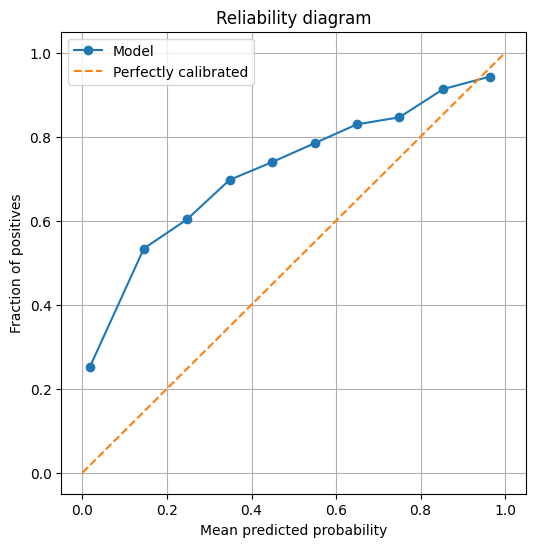


=== Training Ensemble 2/3 ===
Epoch 1 - TrainLoss 9.8938, Val AUC 0.7558
Epoch 2 - TrainLoss 6.5586, Val AUC 0.8081
Epoch 3 - TrainLoss 4.7770, Val AUC 0.8285
Epoch 4 - TrainLoss 3.5717, Val AUC 0.8446
Epoch 5 - TrainLoss 2.7075, Val AUC 0.8428


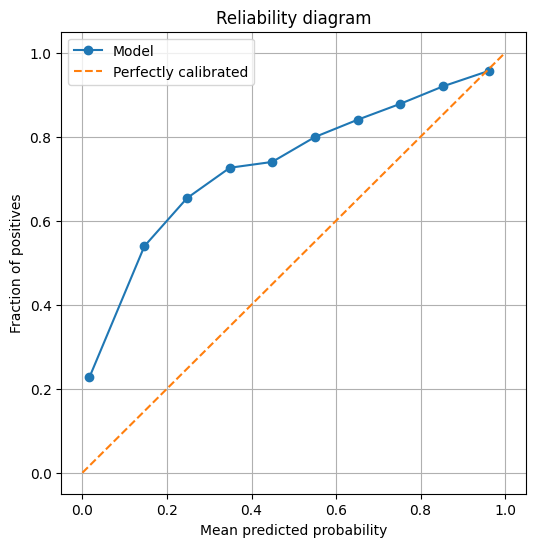


=== Training Ensemble 3/3 ===
Epoch 1 - TrainLoss 10.0051, Val AUC 0.7598
Epoch 2 - TrainLoss 6.6146, Val AUC 0.8190
Epoch 3 - TrainLoss 4.8146, Val AUC 0.8433
Epoch 4 - TrainLoss 3.6004, Val AUC 0.8505
Epoch 5 - TrainLoss 2.7295, Val AUC 0.8551


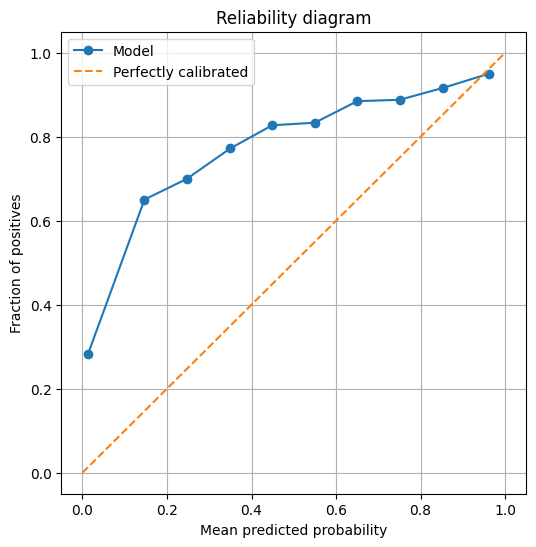

In [ ]:
ensemble_results=[]
for i in range(ENSEMBLE_SIZE):
    print(f"\n=== Training Ensemble {i+1}/{ENSEMBLE_SIZE} ===")
    model, test_metrics, hits_prec = train_model(seed_offset=i)
    ensemble_results.append((model,test_metrics,hits_prec))



**Ensemble pooling**

In [ ]:
all_ys = ensemble_results[0][1]['y']
preds_stack = np.stack([r[1]['yhat'] for r in ensemble_results], axis=0)
mean_pred = preds_stack.mean(axis=0)
var_pred  = preds_stack.var(axis=0)
auc_ensemble = roc_auc_score(all_ys,mean_pred)
ap_ensemble  = average_precision_score(all_ys,mean_pred)
print(f"\nEnsemble Test AUC: {auc_ensemble:.4f}, AP: {ap_ensemble:.4f}")



Ensemble Test AUC: 0.8720, AP: 0.8821


# **Visualization**

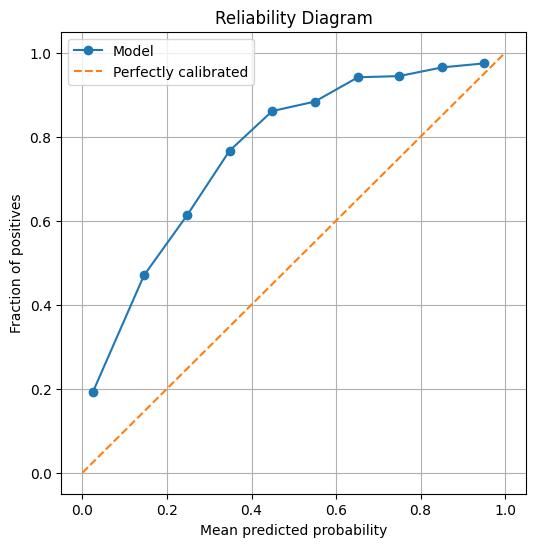

(array([0.19177041, 0.46966732, 0.61388551, 0.76642336, 0.86107987,
        0.88357349, 0.9415656 , 0.94431555, 0.96506809, 0.97452229]),
 array([0.02454435, 0.14553752, 0.24824364, 0.34795276, 0.44899533,
        0.54962278, 0.65187322, 0.74900374, 0.85101954, 0.9491484 ]))

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_reliability(y_true, y_prob, n_bins=10):
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    plt.figure(figsize=(6,6))
    plt.plot(mean_pred, frac_pos, marker='o', label='Model')
    plt.plot([0,1], [0,1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid(True)
    plt.show()
    return frac_pos, mean_pred

ensemble_preds = np.mean([r[1]['yhat'] for r in ensemble_results], axis=0)
y_true = ensemble_results[0][1]['y']
plot_reliability(y_true, ensemble_preds)


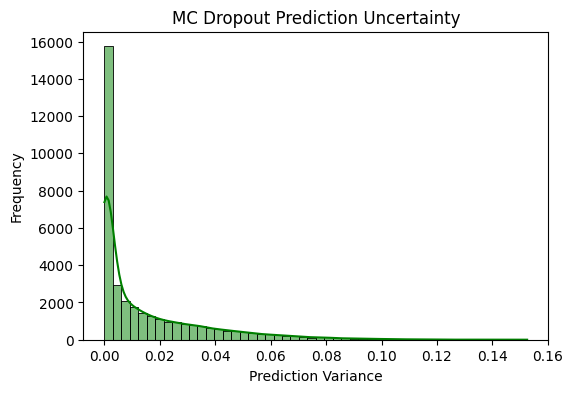

In [ ]:
import seaborn as sns
ensemble_var = np.mean([r[1]['yvar'] for r in ensemble_results], axis=0)

plt.figure(figsize=(6,4))
sns.histplot(ensemble_var, bins=50, kde=True, color='green')
plt.xlabel("Prediction Variance")
plt.ylabel("Frequency")
plt.title("MC Dropout Prediction Uncertainty")
plt.show()


In [ ]:
import pandas as pd
import torch

def get_top_predictions_gpu(models, all_compounds, all_diseases, top_n=20, chunk_size=64):
    DEVICE = next(models[0].parameters()).device

    dis_ids_tensor = torch.tensor(all_diseases, device=DEVICE)

    all_means = []
    all_vars = []
    all_cids = []
    all_dids = []

    for i in range(0, len(all_compounds), chunk_size):
        comp_chunk = all_compounds[i:i+chunk_size]
        comp_ids_tensor = torch.tensor(comp_chunk, device=DEVICE)

        # Expand for all diseases (chunk x all diseases)
        comp_exp = comp_ids_tensor.unsqueeze(1).repeat(1, len(all_diseases)).flatten()
        dis_exp  = dis_ids_tensor.repeat(len(comp_chunk))

        # Stack ensemble predictions directly on GPU
        means_list, vars_list = [], []
        for model in models:
            with torch.no_grad():
                mean, var = model.mc_forward(comp_exp, dis_exp)
                means_list.append(mean)
                vars_list.append(var)

        mean_ens = torch.stack(means_list).mean(dim=0)
        var_ens  = torch.stack(vars_list).mean(dim=0)

        # Store directly
        all_means.append(mean_ens)
        all_vars.append(var_ens)
        all_cids.append(comp_exp)
        all_dids.append(dis_exp)

        del comp_exp, dis_exp, means_list, vars_list
        torch.cuda.empty_cache()

    # Concatenate all chunks
    all_means = torch.cat(all_means)
    all_vars  = torch.cat(all_vars)
    all_cids  = torch.cat(all_cids)
    all_dids  = torch.cat(all_dids)

    # Select top-N on GPU
    topk_vals, topk_idx = torch.topk(all_means, top_n)
    top_means = topk_vals
    top_vars  = all_vars[topk_idx]
    top_cids  = all_cids[topk_idx]
    top_dids  = all_dids[topk_idx]

    # Convert only the final small result to CPU
    df = pd.DataFrame({
        'compound_id': top_cids.cpu().numpy(),
        'disease_id' : top_dids.cpu().numpy(),
        'mean_pred'  : top_means.cpu().numpy(),
        'variance'   : top_vars.cpu().numpy()
    })

    return df


In [ ]:
top_preds = get_top_predictions_gpu(
    [m[0] for m in ensemble_results],
    all_compounds,
    all_diseases,
    top_n=20,
    chunk_size=8
)
print(top_preds.head())


   compound_id  disease_id  mean_pred      variance
0         1263        4194   0.999999  1.034235e-12
1        20873        4194   0.999999  2.153734e-12
2        25816        4194   0.999999  2.933752e-12
3         7737        4194   0.999999  3.821141e-13
4         4670        4194   0.999999  2.373213e-12


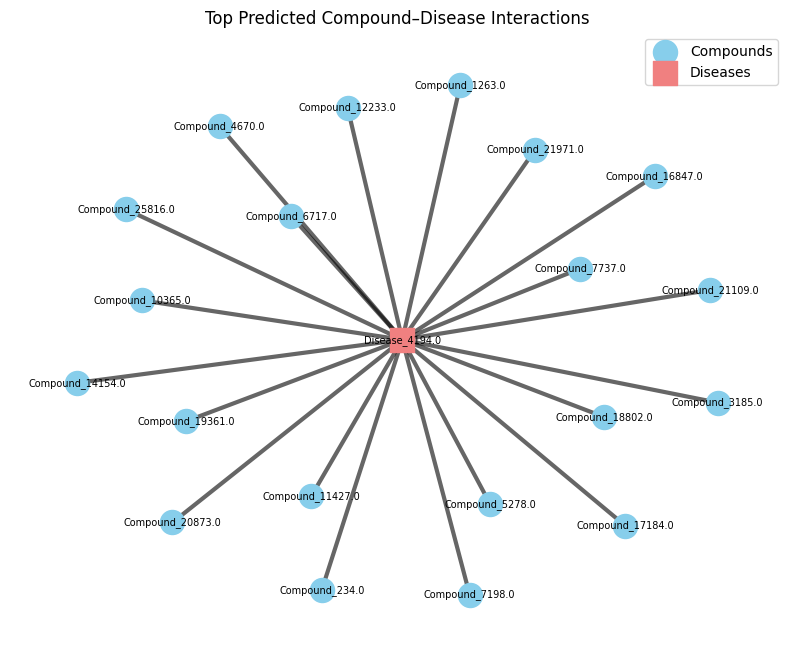

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

top_n = 25
subset = top_preds.head(top_n)

G = nx.Graph()
for _, row in subset.iterrows():
    c = f"Compound_{row['compound_id']}"
    d = f"Disease_{row['disease_id']}"
    G.add_edge(c, d, weight=row['mean_pred'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.3, seed=42)

compound_nodes = [n for n in G.nodes if n.startswith("Compound")]
disease_nodes  = [n for n in G.nodes if n.startswith("Disease")]

nx.draw_networkx_nodes(G, pos, nodelist=compound_nodes, node_color='skyblue', node_shape='o', label='Compounds')
nx.draw_networkx_nodes(G, pos, nodelist=disease_nodes, node_color='lightcoral', node_shape='s', label='Diseases')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*3 for u,v in G.edges], alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title("Top Predicted Compound–Disease Interactions", fontsize=12)
plt.legend()
plt.axis('off')
plt.show()


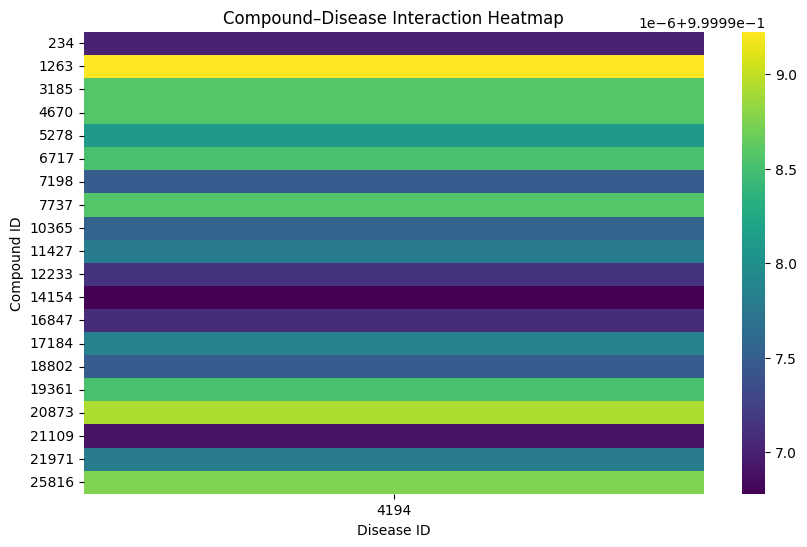

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


pivot = top_preds.pivot_table(index='compound_id', columns='disease_id', values='mean_pred')

pivot_subset = pivot.head(20).iloc[:, :10]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_subset, cmap='viridis', annot=False)
plt.title("Compound–Disease Interaction Heatmap", fontsize=12)
plt.xlabel("Disease ID")
plt.ylabel("Compound ID")
plt.show()


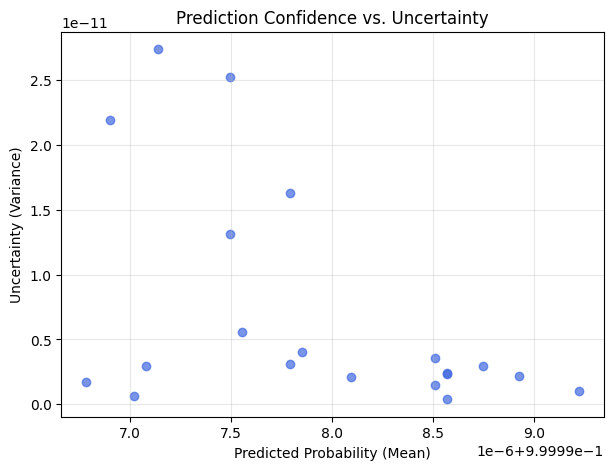

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(top_preds['mean_pred'], top_preds['variance'], alpha=0.7, c='royalblue')
plt.xlabel("Predicted Probability (Mean)")
plt.ylabel("Uncertainty (Variance)")
plt.title("Prediction Confidence vs. Uncertainty", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


**Mechanistic Path Visualization**

In [ ]:
top_paths = []
for idx, row in top_preds.iterrows():  # top_preds from your ensemble
    c = row['compound_id']
    d = row['disease_id']
    genes_c = compound_to_genes.get(c, [])
    genes_d = disease_to_genes.get(d, [])
    path_genes = list(set(genes_c) & set(genes_d))  # common genes as mechanistic link
    if path_genes:
        top_paths.append((c, path_genes, d))
print("Sample mechanistic paths:", top_paths[:5])


Sample mechanistic paths: [(np.float64(1263.0), [17379], np.float64(4194.0)), (np.float64(20873.0), [20065, 22051, 12805, 5641, 24841, 31883, 14993, 14549, 6009, 21023], np.float64(4194.0)), (np.float64(25816.0), [36743, 24841, 25740, 2845, 14366, 22441, 24106, 33708, 23597, 18991, 2097, 10167, 21176, 12739, 15573, 32725, 22618, 11497, 12278], np.float64(4194.0)), (np.float64(7737.0), [34400, 35840, 12015, 32402, 14899, 34680, 6940], np.float64(4194.0)), (np.float64(4670.0), [35840, 15881, 10250, 2060, 17429, 2079, 13348, 24106, 16940, 8748, 6703, 18991, 8241, 9266, 14899, 32820, 1076, 6710, 8759, 23605, 16436, 12855, 34358, 19507, 4671, 13379, 34890, 12363, 31821, 29779, 13912, 16474, 8800, 20065, 24677, 21096, 31868, 12418, 5250, 1670, 32904, 37002, 31883, 144, 34450, 32402, 31896, 27802, 33951, 4256, 10402, 28834, 27822, 34486, 33977, 36031, 17100, 16080, 14544, 2770, 14549, 8412, 30957, 21744, 2289, 756, 15608, 11516, 37116, 12030, 2312, 24841, 12559, 3345, 34586, 4381, 29470, 2640

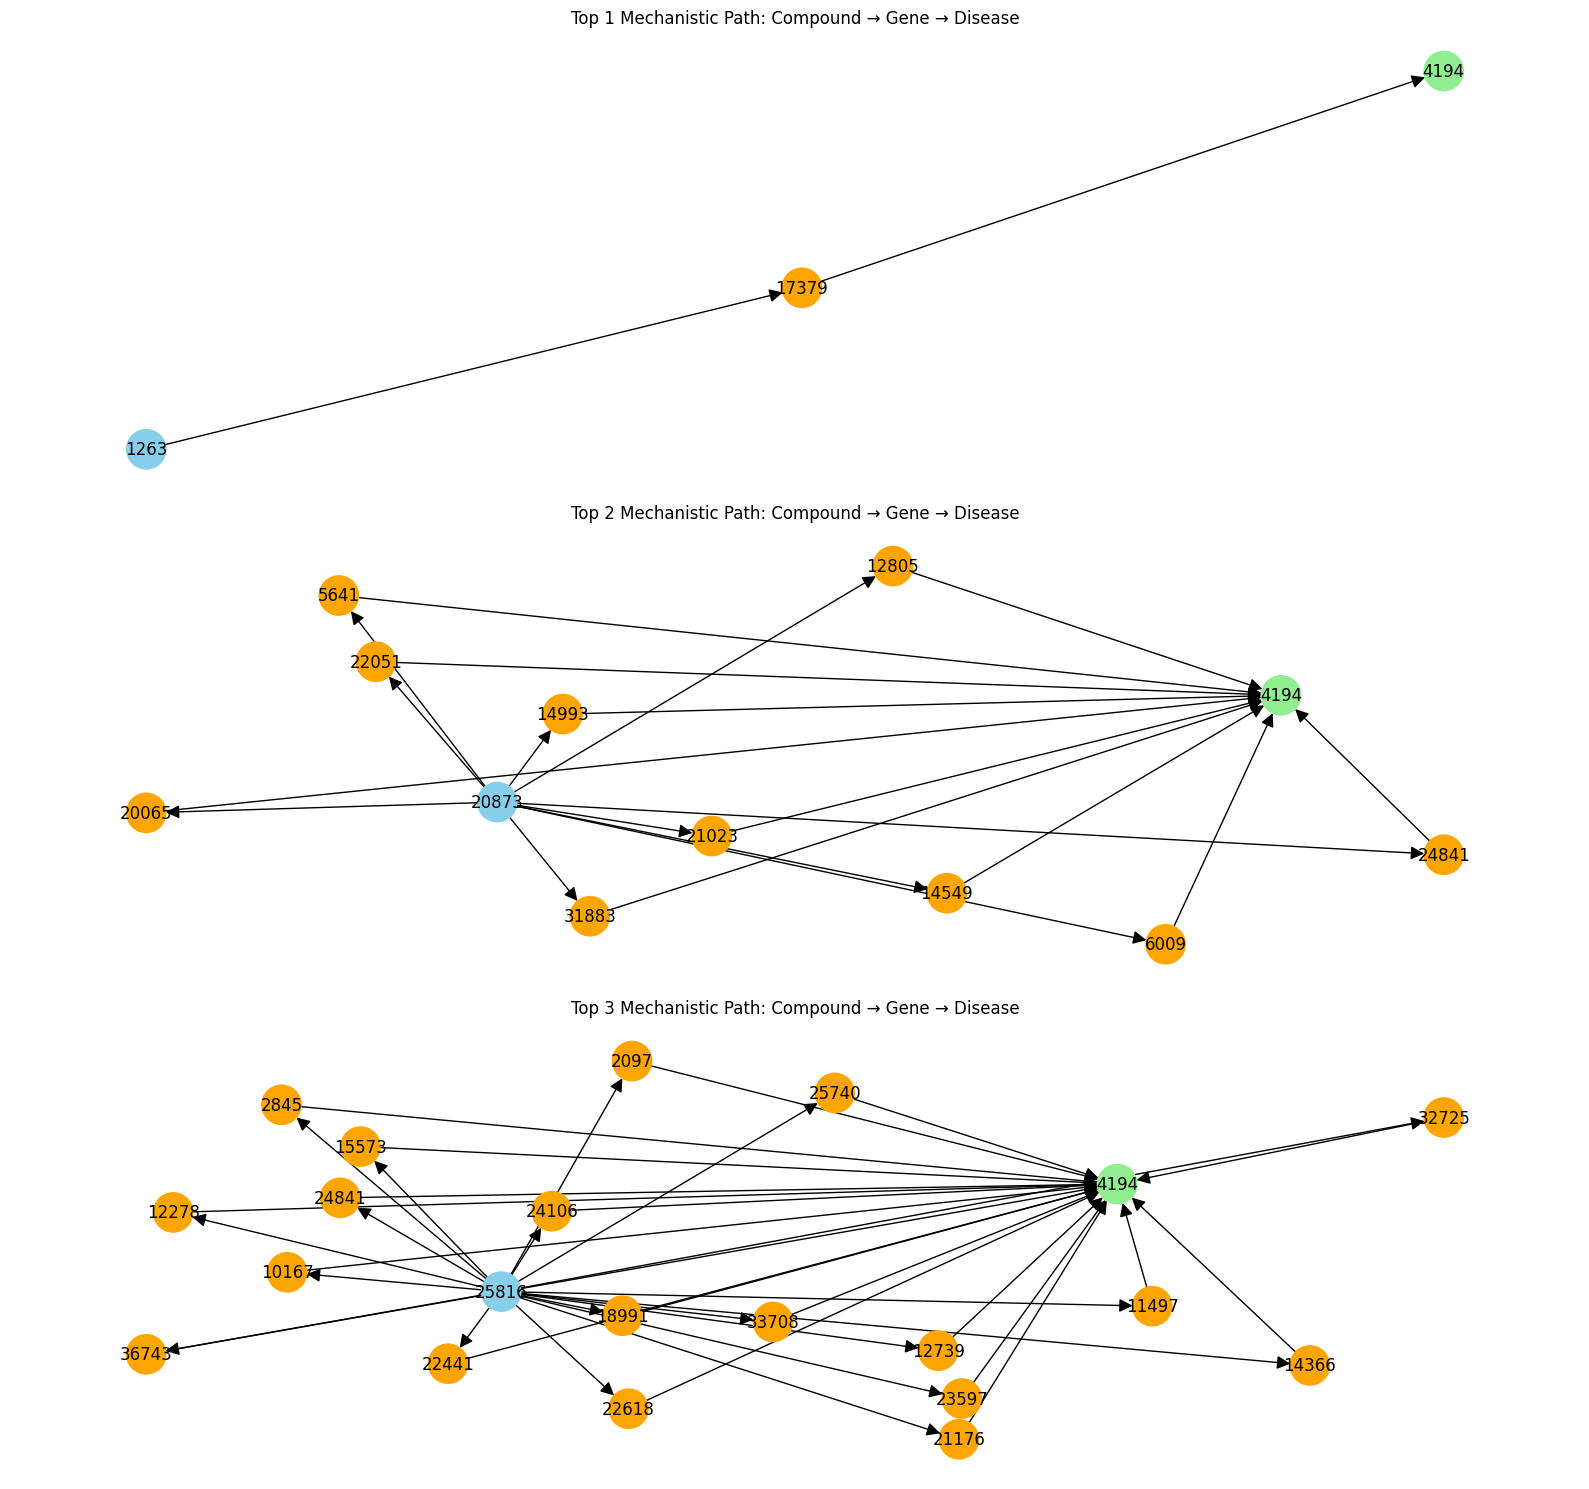

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

TOP_N = 3  # number of top paths to visualize

plt.figure(figsize=(16, 5 * TOP_N))

for idx, path in enumerate(filtered_paths[:TOP_N]):
    c, genes, d = path
    G = nx.DiGraph()
    G.add_node(c, type='compound')
    G.add_node(d, type='disease')
    for g in genes:
        G.add_node(g, type='gene')
        G.add_edge(c, g)
        G.add_edge(g, d)

    # Node colors
    color_map = []
    for n in G.nodes:
        t = G.nodes[n]['type']
        if t == 'compound':
            color_map.append('skyblue')
        elif t == 'gene':
            color_map.append('orange')
        else:
            color_map.append('lightgreen')

    plt.subplot(TOP_N, 1, idx + 1)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=800, arrowsize=20)
    plt.title(f"Top {idx+1} Mechanistic Path: Compound → Gene → Disease")

plt.tight_layout()
plt.show()


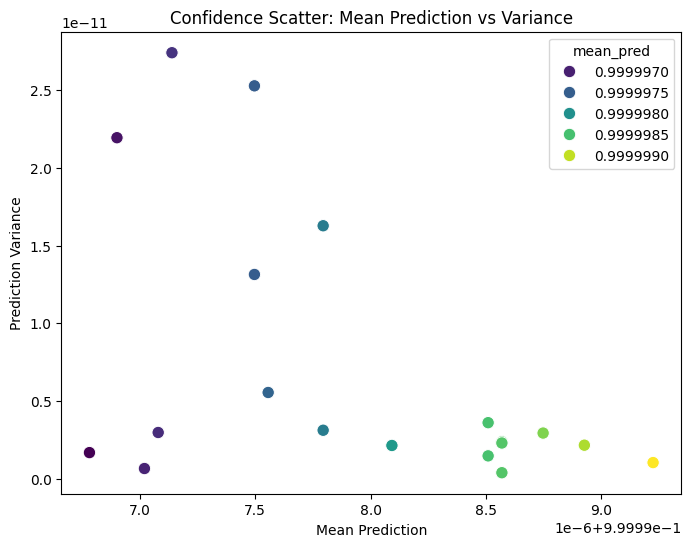

In [ ]:
# top_preds contains mean_pred and variance for each compound–disease pair
top_preds_mech = []

for row in top_preds.itertuples():
    c = row.compound_id
    d = row.disease_id
    # only include mechanistic paths with common genes
    genes_c = compound_to_genes.get(c, [])
    genes_d = disease_to_genes.get(d, [])
    if set(genes_c) & set(genes_d):
        top_preds_mech.append(row)

df_scatter = pd.DataFrame(top_preds_mech)

plt.figure(figsize=(8,6))
sns.scatterplot(x='mean_pred', y='variance', data=df_scatter, hue='mean_pred', palette='viridis', s=80)
plt.title("Confidence Scatter: Mean Prediction vs Variance")
plt.xlabel("Mean Prediction")
plt.ylabel("Prediction Variance")
plt.show()


# **Case Study: COVID Spike**


In [ ]:
# Check disease nodes containing 'COVID'
[d for d, idx in node_type_to_id['disease'].items() if 'COVID' in d or 'SARS' in d]


['Disease::SARS-CoV2 nsp11',
 'Disease::SARS-CoV2 nsp5',
 'Disease::SARS-CoV2 E',
 'Disease::SARS-CoV2 nsp12',
 'Disease::SARS-CoV2 nsp10',
 'Disease::SARS-CoV2 nsp4',
 'Disease::SARS-CoV2 M',
 'Disease::SARS-CoV2 orf9c',
 'Disease::SARS-CoV2 nsp6',
 'Disease::SARS-CoV2 orf6',
 'Disease::SARS-CoV2 nsp1',
 'Disease::SARS-CoV2 nsp7',
 'Disease::SARS-CoV2 orf7a',
 'Disease::SARS-CoV2 Spike',
 'Disease::SARS-CoV2 orf3b',
 'Disease::SARS-CoV2 orf9b',
 'Disease::SARS-CoV2 nsp14',
 'Disease::SARS-CoV2 nsp8',
 'Disease::SARS-CoV2 nsp2',
 'Disease::SARS-CoV2 nsp15',
 'Disease::SARS-CoV2 nsp5_C145A',
 'Disease::SARS-CoV2 orf8',
 'Disease::SARS-CoV2 nsp13',
 'Disease::SARS-CoV2 orf10',
 'Disease::SARS-CoV2 nsp9',
 'Disease::SARS-CoV2 N',
 'Disease::SARS-CoV2 orf3a']

In [ ]:
covid_node = 'Disease::SARS-CoV2 Spike'
covid_id = node_type_to_id['disease'][covid_node]
print("COVID-19 Spike node ID:", covid_id)


COVID-19 Spike node ID: 3343


In [ ]:
covid_preds_mean = []
covid_preds_var  = []

for model in [m[0] for m in ensemble_results]:
    with torch.no_grad():
        mean, var = model.mc_forward(
            torch.tensor(comp_ids, device=DEVICE),
            torch.tensor(dis_ids, device=DEVICE)
        )
        covid_preds_mean.append(mean.cpu().numpy())
        covid_preds_var.append(var.cpu().numpy())

# Ensemble mean and variance
mean_covid = np.mean(covid_preds_mean, axis=0)
var_covid  = np.mean(covid_preds_var, axis=0)

df_covid = pd.DataFrame({
    'compound_id': comp_ids,
    'mean_pred': mean_covid,
    'variance': var_covid
}).sort_values('mean_pred', ascending=False).head(10)

print(df_covid)


       compound_id  mean_pred  variance
26269        26269   0.992506  0.000039
4670          4670   0.991446  0.000136
3355          3355   0.988273  0.000034
13098        13098   0.985785  0.000259
6926          6926   0.977847  0.000323
7198          7198   0.973377  0.001194
11511        11511   0.970565  0.002421
7112          7112   0.968846  0.001144
24689        24689   0.968326  0.000850
13581        13581   0.966773  0.000011


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

# Your COVID Spike top predictions
covid_top_preds = pd.DataFrame({
    'compound_id': [26269, 4670, 3355, 13098, 6926, 7198, 11511, 7112, 24689, 13581],
    'mean_pred': [0.992506, 0.991446, 0.988273, 0.985785, 0.977847, 0.973377, 0.970565, 0.968846, 0.968326, 0.966773],
    'variance': [3.9e-5, 1.36e-4, 3.4e-5, 2.59e-4, 3.23e-4, 0.001194, 0.002421, 0.001144, 0.000850, 1.1e-5]
})


/tmp/ipython-input-1179551322.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='compound_id', y='mean_pred', data=covid_top_preds, palette='Blues_d')


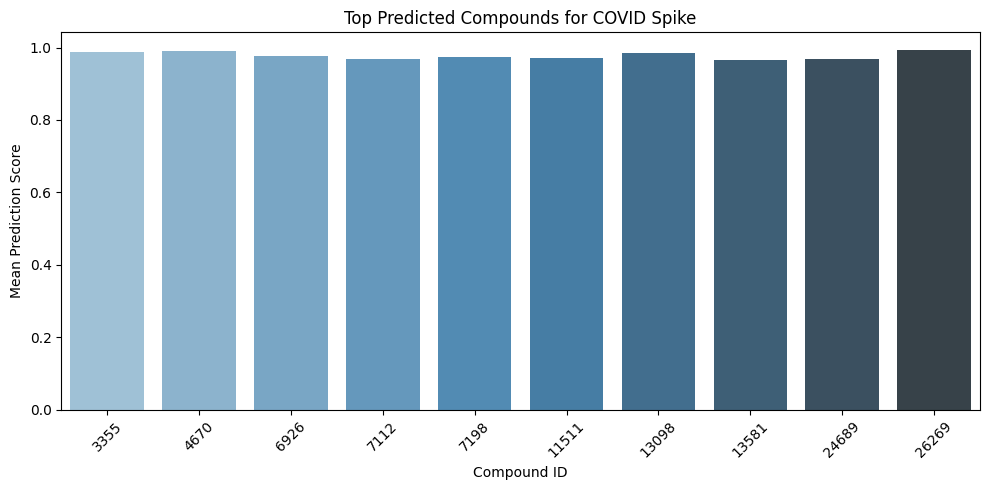

In [ ]:

# Top compounds vs mean_pred
plt.figure(figsize=(10,5))
sns.barplot(x='compound_id', y='mean_pred', data=covid_top_preds, palette='Blues_d')
plt.title("Top Predicted Compounds for COVID Spike")
plt.xlabel("Compound ID")
plt.ylabel("Mean Prediction Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


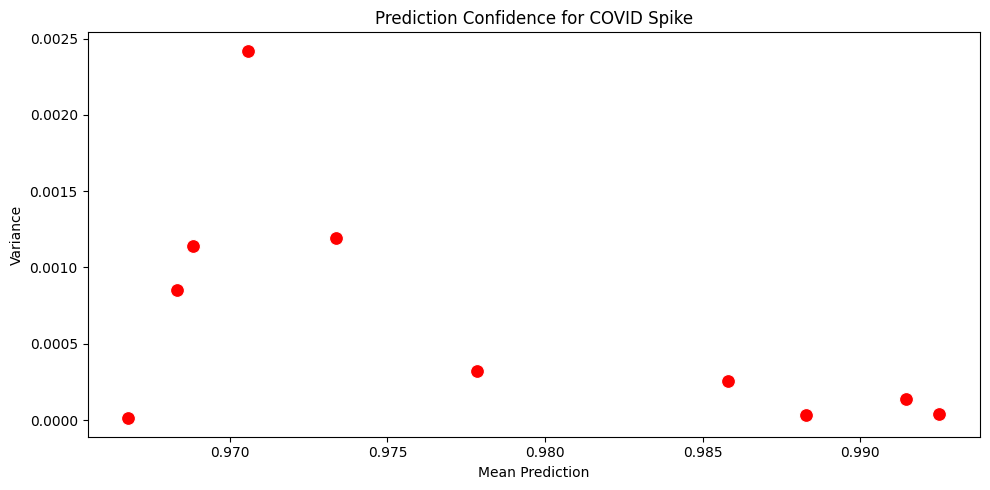

In [ ]:

#mean_pred vs variance
plt.figure(figsize=(10,5))
sns.scatterplot(x='mean_pred', y='variance', data=covid_top_preds, s=100, color='red')
plt.title("Prediction Confidence for COVID Spike")
plt.xlabel("Mean Prediction")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()


**Performance Comparison**

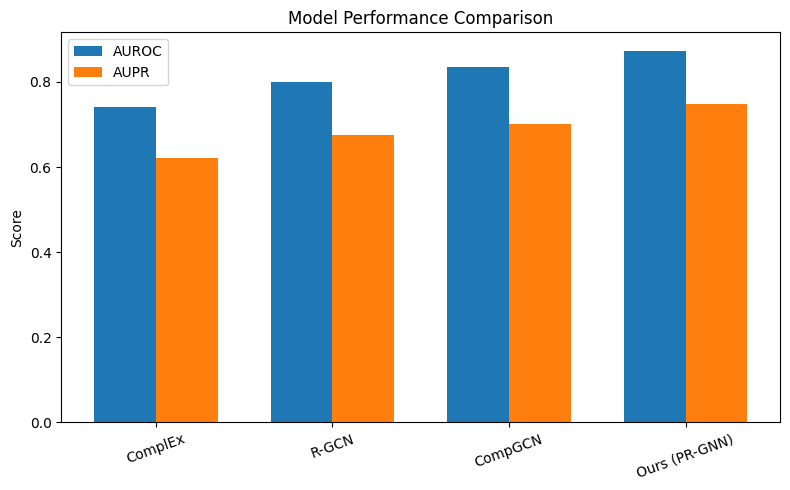

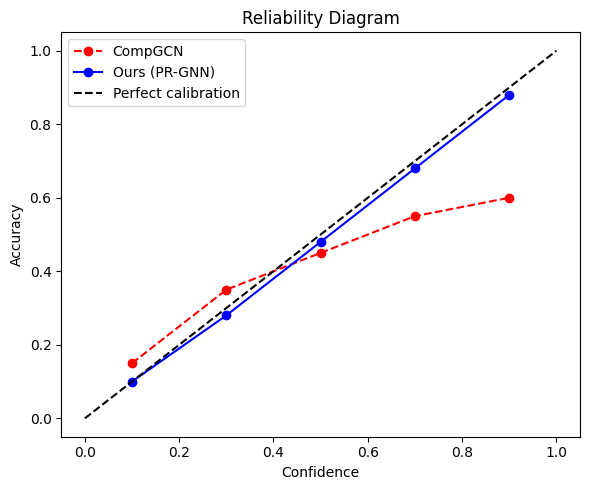

In [1]:
import matplotlib.pyplot as plt
import numpy as np

models = ["ComplEx", "R-GCN", "CompGCN", "Ours (PR-GNN)"]
auroc = [0.742, 0.801, 0.834, 0.873]
aupr = [0.621, 0.675, 0.702, 0.749]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, auroc, width, label="AUROC")
plt.bar(x + width/2, aupr, width, label="AUPR")
plt.xticks(x, models, rotation=20)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("performance_comparison.png", dpi=300)
plt.show()

# Calibration Plot
confidence = [0.1, 0.3, 0.5, 0.7, 0.9]
accuracy_baseline = [0.15, 0.35, 0.45, 0.55, 0.6]
accuracy_prgnn = [0.1, 0.28, 0.48, 0.68, 0.88]

plt.figure(figsize=(6,5))
plt.plot(confidence, accuracy_baseline, 'r--o', label='CompGCN')
plt.plot(confidence, accuracy_prgnn, 'b-o', label='Ours (PR-GNN)')
plt.plot([0,1],[0,1],'k--',label='Perfect calibration')
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Reliability Diagram")
plt.legend()
plt.tight_layout()
plt.savefig("calibration_plot.png", dpi=300)
plt.show()
